## The LeNet Architecture

In [1]:
# dlframework.nn.conv.lenet.py

from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers.core import Activation
from keras import backend as K


In [4]:
class LeNet:
    @staticmethod
    def build( width, height, depth, classes):
        
        #initialize the model
        model = Sequential()
        inputShape = (height, width, depth)
        
        # if we are using "channels first", update the input shape
        if K.image_data_format() == "channel_first":
            inputShape = (depth, height, width)
            
        # first set of CONV => RELU => POOL layers
        model.add(Conv2D(20, (5, 5), input_shape=inputShape, padding="same"))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
        
        # second set of CONV => RELU => POOL layers
        model.add(Conv2D(50, (5, 5), padding="same"))
        model.add(Activation("relu"))
        model.add(MaxPooling2D((2,2), strides=(2,2)))
        
        # first (and only) set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(500))
        model.add(Activation("relu"))
        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation("softmax"))
        
        return model

## LeNet on MNIST

In [5]:
# lenet_mnist.py

from dlframework.nn.conv import LeNet
from keras.optimizers import SGD
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import datasets

import numpy as np
import matplotlib.pyplot as plt
from keras import backend as K

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [9]:
# grab the MNIST dataset
print("[INFO] accessing MNIST...")
dataset = datasets.fetch_openml("mnist_784")
data = dataset.data


In [10]:
print(data.shape)

(70000, 784)


In [19]:
if K.image_data_format()=="channel_first":
    data = data.reshape(data.shape[0], 1, 28, 28)
else:
    data =data.reshape(data.shape[0], 28, 28, 1)

In [22]:
# scale the input data to the range [0, 1] and perform a train/test split
X_train, X_test, y_train, y_test = train_test_split(data/255.0, dataset.target.astype("int"),
                                                    test_size=0.25, random_state=42)

In [23]:
# convert the labels from integers to vectors
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

In [24]:
print("[INFO] compiling model...")
model = LeNet.build(28, 28, 1, classes =10)
opt = SGD(lr = 0.01)
model.compile(loss = "categorical_crossentropy", optimizer = opt,
             metrics = ["accuracy"])


[INFO] compiling model...


In [26]:
print("[INFO] training the network...")
H = model.fit(X_train, y_train, validation_data=(X_test, y_test),
          epochs = 20, batch_size=128, verbose=1)

[INFO] training the network...
Train on 52500 samples, validate on 17500 samples
Epoch 1/20
52500/52500 [==============================] - 41s 780us/step - loss: 0.6415 - accuracy: 0.8462 - val_loss: 0.5524 - val_accuracy: 0.8571
Epoch 2/20
52500/52500 [==============================] - 44s 829us/step - loss: 0.4975 - accuracy: 0.8711 - val_loss: 0.4565 - val_accuracy: 0.8817
Epoch 3/20
52500/52500 [==============================] - 48s 910us/step - loss: 0.4250 - accuracy: 0.8859 - val_loss: 0.4016 - val_accuracy: 0.8942
Epoch 4/20
52500/52500 [==============================] - 47s 886us/step - loss: 0.3801 - accuracy: 0.8949 - val_loss: 0.3695 - val_accuracy: 0.8966
Epoch 5/20
52500/52500 [==============================] - 50s 944us/step - loss: 0.3489 - accuracy: 0.9024 - val_loss: 0.3417 - val_accuracy: 0.9043
Epoch 6/20
52500/52500 [==============================] - 52s 983us/step - loss: 0.3252 - accuracy: 0.9078 - val_loss: 0.3210 - val_accuracy: 0.9114
Epoch 7/20
52500/52500 [=

In [28]:
print("[INFO] evaluating the network...")
y_pred = model.predict(X_test)
print(classification_report(y_test.argmax(axis=1),
                           y_pred.argmax(axis=1),
                           target_names = [str(i) for i in lb.classes_ ]))

[INFO] evaluating the network...
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1714
           1       0.97      0.98      0.97      1977
           2       0.89      0.95      0.92      1761
           3       0.92      0.91      0.92      1806
           4       0.93      0.95      0.94      1587
           5       0.93      0.94      0.93      1607
           6       0.97      0.95      0.96      1761
           7       0.93      0.96      0.95      1878
           8       0.95      0.90      0.93      1657
           9       0.96      0.89      0.92      1752

    accuracy                           0.94     17500
   macro avg       0.94      0.94      0.94     17500
weighted avg       0.94      0.94      0.94     17500



In [29]:
model.save("lenet_mnist.hdf5")

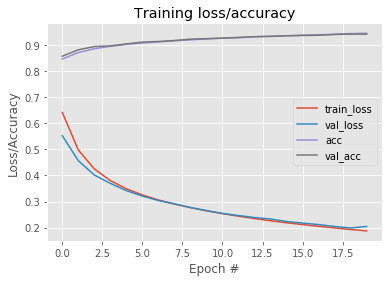

In [31]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0,20), H.history["loss"], label="train_loss")
plt.plot(np.arange(0,20), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0,20), H.history["accuracy"], label="acc")
plt.plot(np.arange(0,20), H.history["val_accuracy"], label="val_acc")
plt.title("Training loss/accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()